# Makemore pt 2
Build a character-level language model that has greater than one character of context using feature vectors.
It follows [Bengio et al 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [70]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
# Load names from file
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [72]:
# Create vocab of characters to integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print('stoi', stoi)
print('itos', itos)

stoi {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [73]:
# Create dataset
block_size = 3 # char context length
X, Y = [], [] # X = Data, Y = Target
for w in words:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch] # next char to be predicted and added to context
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape, X.dtype, Y.dtype)

emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
victoria
madison
luna
grace
chloe
penelope
layla
riley
zoey
nora
lily
eleanor
hannah
lillian
addison
aubrey
ellie
stella
natalie
zoe
leah
hazel
violet
aurora
savannah
audrey
brooklyn
bella
claire
skylar
lucy
paisley
everly
anna
caroline
nova
genesis
emilia
kennedy
samantha
maya
willow
kinsley
naomi
aaliyah
elena
sarah
ariana
allison
gabriella
alice
madelyn
cora
ruby
eva
serenity
autumn
adeline
hailey
gianna
valentina
isla
eliana
quinn
nevaeh
ivy
sadie
piper
lydia
alexa
josephine
emery
julia
delilah
arianna
vivian
kaylee
sophie
brielle
madeline
peyton
rylee
clara
hadley
melanie
mackenzie
reagan
adalynn
liliana
aubree
jade
katherine
isabelle
natalia
raelynn
maria
athena
ximena
arya
leilani
taylor
faith
rose
kylie
alexandra
mary
margaret
lyla
ashley
amaya
eliza
brianna
bailey
andrea
khloe
jasmine
melody
iris
isabel
norah
annabelle
valeria
emerson
adalyn
ryl

In [93]:
# Build C matrix = character-level embeddings to be used as inputs vectors
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)

# Indexing into C is the same as one hot encoded vector @ C
emb = C[X]

# Define the weight matrix
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)

# Output layer
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

# Sum number of parameters
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

print(sum(p.numel() for p in parameters))

# Hyperparameter search through possibl elearning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# print(lrs)

lri, lossi = [], []
# Full training loop
for i in range(100000):

    # Minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))

    emb = C[X[ix]]

    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2

    # Softmax
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # prob = F.softmax(logits, dim=1)
    # print(prob[0,:].sum())

    # # Compute loss
    # loss = - prob[torch.arange(32), Y].log().mean()

    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    # Update parameters
    # lr = lrs[i] # used for testing
    lr = 0.1

    for p in parameters:
        p.data -= lr * p.grad
    
    # Track stats    
    # lri.append(lr)
    # lossi.append(loss.item())


3481
18.030223846435547
17.83734703063965
15.332348823547363
10.894089698791504
14.199312210083008
14.274917602539062
14.3135404586792
12.300741195678711
10.040237426757812
11.158474922180176
10.289730072021484
11.024710655212402
10.87092113494873
12.783376693725586
8.679424285888672
9.9063720703125
10.0186767578125
8.84988784790039
7.917875289916992
10.560972213745117
9.2782621383667
6.624863147735596
8.3270902633667
8.216208457946777
8.325282096862793
7.658822536468506
7.374983787536621
7.16405725479126
8.096989631652832
6.998847007751465
5.9949774742126465
5.67518424987793
7.90694522857666
7.337885856628418
9.093775749206543
6.399721622467041
5.465460777282715
5.991443634033203
7.300652027130127
5.878775596618652
4.831704616546631
5.656726360321045
5.944055557250977
5.476216793060303
6.514827728271484
7.061666011810303
5.472467422485352
5.370229721069336
4.432703018188477
5.901346683502197
5.912269115447998
5.99200963973999
4.956422805786133
5.252225399017334
3.8693575859069824
4.16

In [85]:
# Eval (trying to beat loss = 2.17)
emb = C[X]

h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2

# Softmax
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.655900478363037


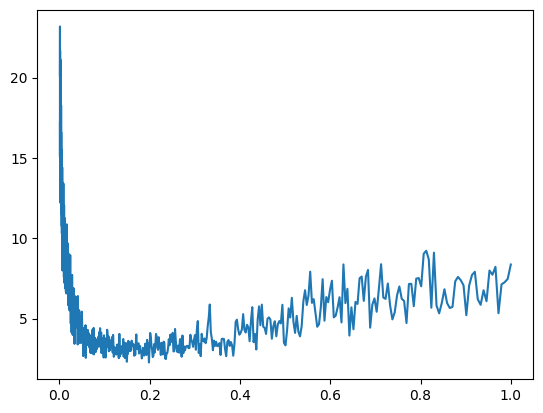

In [90]:
# By comparing loss as a function of learning rate, we can deduce what should be a good learning rate.
plt.plot(lri, lossi)